In [1]:
import networkx as nx

def readNetwork(filename):
    f = open(filename, "r")
    net = {}
    n = int(f.readline())
    net['noNodes'] = n
    mat = []
    for i in range(n):
        mat.append([])
        line = f.readline()
        elems = line.split(",")
        for j in range(n):
            mat[-1].append(int(elems[j]))
    net["mat"] = mat 
    degrees = []
    noEdges = 0
    for i in range(n):
        d = 0
        for j in range(n):
            if (mat[i][j] == 1):
                d += 1
            if (j > i):
                noEdges += mat[i][j]
        degrees.append(d)
    net["noEdges"] = noEdges
    net["degrees"] = degrees
    f.close()
    return net

In [2]:
from utils import euclideanDistance

def read_berlin(filename):
    mat = {}
    f = open(filename, "r")
    words = f.readline().split(' ')
    while words[0] != "DIMENSION:":
        words = f.readline().split(' ')
    mat['noNodes'] = int(words[1])
    f.readline()
    f.readline()
    lines = []
    for i in range(0, mat['noNodes']):
        words = f.readline().split(" ")
        lines.append((float(words[1]), float(words[2])))

    mat['mat'] = []
    for i in range(0, mat['noNodes']):
        mat['mat'].append([])
        for j in range(0, mat['noNodes']):
            mat['mat'][i].append(0.0)
    for i in range(0, mat['noNodes'] - 1):
        for j in range(i + 1, mat['noNodes']):
            mat['mat'][i][i] = 0.0
            mat['mat'][j][i] = mat['mat'][i][j] = euclideanDistance(lines[i], lines[j])
    return mat

In [3]:
import os 

crtDir =  os.getcwd()
filePath = os.path.join(crtDir, 'data', 'berlin52.txt')
#network = readNetwork(filePath)
network = read_berlin(filePath)

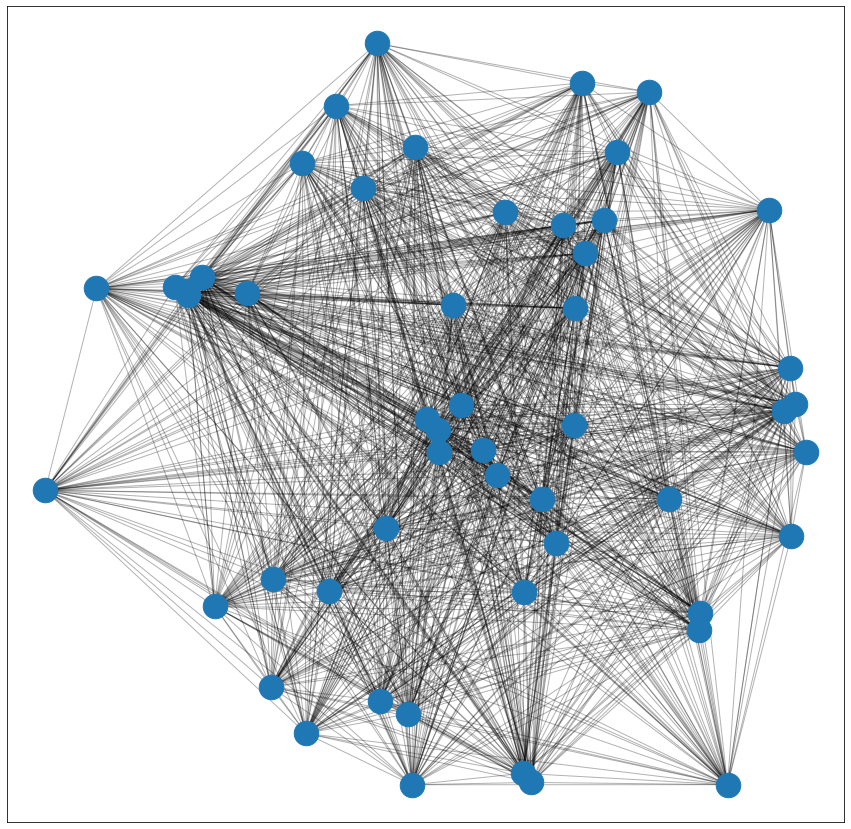

In [4]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
import warnings 

warnings.simplefilter('ignore')

A=np.matrix(network["mat"])
G=nx.from_numpy_matrix(A)
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(15, 15))  # image is 8 x 8 inches 
nx.draw_networkx_nodes(G, pos, node_size=600, cmap=plt.cm.RdYlBu)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)

In [5]:
def modularity(communities, param):
    mat = param['mat']
    Q = 0.0
    for i in range(len(communities) - 1):
        Q += mat[communities[i]][communities[i+1]]
    return Q + mat[communities[len(communities) - 1]][communities[0]]

In [6]:
from random import randint, uniform, random
from numpy.random import choice
import heapq

class GA:
    def __init__(self, param = None, problParam = None):
        self.__param = param
        self.__problParam = problParam
        self.__population = []

        
    @property
    def population(self):
        return self.__population
    
    def initialisation(self):
        for _ in range(0, self.__param['popSize']):
            c = Chromosome(self.__problParam)
            c.initialization(self.__problParam['noNodes'], self.__problParam['mat'])
            self.__population.append(c)
        heapq.heapify(self.__population)
    
    def evaluation(self):
        aux = []
        for i in range(0, self.__param['popSize']):
            c = heapq.heappop(self.__population)
            c.fitness = self.__problParam['function'](c.repres,problParam)
            aux.append(c)
        heapq.heapify(aux)
        self.__population = aux
            
    def bestChromosome(self):
        c = heapq.heappop(self.__population)
        heapq.heappush(self.__population,c)
        return c
        
    def worstChromosome(self):
        best = self.bestChromosome()
        aux = []
        for i in range(0, self.__param['popSize']):
            c = heapq.heappop(self.__population)
            if (c.fitness > best.fitness):
                best = c
            aux.append(c)
        heapq.heapify(aux)
        self.__population = aux
        return best

    def getElem(self,pos):
        elem = self.bestChromosome()
        aux = []
        for i in range(0, self.__param['popSize']):
            c = heapq.heappop(self.__population)
            if (pos == i):
                elem = c
            aux.append(c)
        heapq.heapify(aux)
        self.__population = aux
        return elem

    def selection(self):
        pos1 = randint(-1, self.__param['popSize'] - 1)
        pos2 = randint(-1, self.__param['popSize'] - 1)
        if (self.getElem(pos1).fitness < self.getElem(pos2).fitness):
            return pos1
        else:
            return pos2
    
    def selectionRoulette(self):
        # Calculate population distances cumulative sums and pick probabilty
        tot_sum = 0
        cum_sums = []
        aux = []
        for i in range(0, self.__param['popSize']):
            c = heapq.heappop(self.__population)
            tot_sum += c.fitness
            cum_sums.append(tot_sum)
            aux.append(c)
        heapq.heapify(aux)
        self.__population = aux
        probs = [(cs / tot_sum) for cs in cum_sums]

        # For each free place in mating pool
        for _ in range(self.__param['popSize']):
            # Spin the roulette
            roulette = random()

            # Find first path with probability higher than roulette number
            for i, prob in enumerate(probs):
                if roulette <= prob:
                    return i

    def oneGeneration(self):
        newPop = []
        heapq.heapify(newPop)
        for _ in range(self.__param['popSize']):
            p1 = self.getElem(self.selection())
            p2 = self.getElem(self.selection())
            off = p1.crossover(p2)
            off.mutation()
            heapq.heappush(newPop, off)
        # luam cea mai buna jumatate din generatia parintiilor + cea mai buna jumatate din generatia copiilor => generatie noua
        mixtPop = [] 
        heapq.heapify(mixtPop)
        for i in range(0, self.__param['popSize'] // 2):
            c1 = heapq.heappop(newPop)
            c2 = heapq.heappop(self.__population)
            heapq.heappush(mixtPop, c1)
            heapq.heappush(mixtPop, c2)
        self.__population = mixtPop
        self.evaluation()

In [8]:
from Chromosome import Chromosome
from random import seed 
from utils import generateNewInteger

# initialise de GA parameters
gaParam = {'popSize' : 200, 'noGen' : 2000, 'pc' : 0.8, 'pm' : 0.1}
# problem parameters
problParam = {'min' : 1, 'max' : network['noNodes'], 'function' : modularity, 'noDim' : network['noNodes'], 'noNodes':network['noNodes'], 'mat': network['mat']}

ga = GA(gaParam, problParam)
ga.initialisation()
ga.evaluation()

for g in range(gaParam['noGen']):
    ga.oneGeneration()
    bestChromo = ga.bestChromosome()
    worstChromo = ga.worstChromosome()
    print('Best solution in generation ' + str(g) + ' is: x = ' + str(bestChromo.repres) + ' f(x) = ' + str(bestChromo.fitness))
    print('Worst solution in generation ' + str(g) + ' is: x = ' + str(worstChromo.repres) + ' f(x) = ' + str(worstChromo.fitness))
    print()

7946.759451185599
Worst solution in generation 1962 is: x = [14, 5, 48, 35, 34, 33, 43, 21, 45, 36, 38, 6, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 30, 22, 46, 19, 28, 15, 49, 29, 1, 41, 20, 16, 2, 17, 0, 39, 37, 47, 23, 3, 24, 11, 27, 26, 25, 12, 13, 4] f(x) = 12972.763592873362

Best solution in generation 1963 is: x = [5, 3, 24, 11, 27, 26, 25, 46, 12, 13, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 30, 22, 19, 28, 15, 49, 29, 1, 6, 41, 20, 16, 2, 17, 21, 0, 48, 35, 34, 33, 43, 45, 36, 38, 39, 37, 47, 23, 4, 14] f(x) = 7946.759451185599
Worst solution in generation 1963 is: x = [10, 21, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 30, 22, 26, 25, 46, 12, 19, 15, 49, 29, 1, 6, 41, 45, 20, 28, 16, 2, 17, 0, 48, 35, 34, 33, 43, 36, 38, 39, 37, 47, 23, 4, 14, 5, 3, 24, 11, 27, 13, 51] f(x) = 12955.844560280888

Best solution in generation 1964 is: x = [5, 3, 24, 11, 27, 26, 25, 46, 12, 13, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 30, 22, 19, 28, 15, 49, 29, 1, 6, 41, 20, 16, 2, 17, 21,